In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install librosa pandas numpy matplotlib seaborn scipy scikit-learn imbalanced-learn tensorflow

In [24]:
import numpy as np
import pandas as pd
import librosa
import os
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
# Configuration
SAMPLE_RATE = 1000  # Hz
DURATION = 5  # seconds
TARGET_LENGTH = 5000  # samples (SAMPLE_RATE * DURATION)
LOWCUT = 20  # Hz
HIGHCUT = 400  # Hz

# Paths
DATA_DIR = r'drive/MyDrive/pcg_data2/training_data/training_data'
CSV_PATH = r'drive/MyDrive/pcg_data2/training_data.csv'

print(f"Data Directory: {DATA_DIR}")
print(f"CSV Path: {CSV_PATH}")
print(f"Directory exists: {os.path.exists(DATA_DIR)}")
print(f"CSV exists: {os.path.exists(CSV_PATH)}")

Data Directory: drive/MyDrive/pcg_data2/training_data/training_data
CSV Path: drive/MyDrive/pcg_data2/training_data.csv
Directory exists: True
CSV exists: True


In [26]:
# Load CSV with patient-level labels
df = pd.read_csv(CSV_PATH)
print(f"Total patients in CSV: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMurmur distribution:")
print(df['Murmur'].value_counts())

# Filter out 'Unknown' labels (we only want binary classification)
df = df[df['Murmur'] != 'Unknown'].copy()
print(f"\nAfter removing Unknown: {len(df)} patients")

# Create binary labels: Present=1 (Abnormal), Absent=0 (Normal)
df['Label'] = (df['Murmur'] == 'Present').astype(int)
print(f"\nLabel distribution:")
print(df['Label'].value_counts())
print(f"Class balance: {df['Label'].value_counts(normalize=True)}")

Total patients in CSV: 942

Columns: ['Patient ID', 'Locations', 'Age', 'Sex', 'Height', 'Weight', 'Pregnancy status', 'Murmur', 'Murmur locations', 'Most audible location', 'Systolic murmur timing', 'Systolic murmur shape', 'Systolic murmur grading', 'Systolic murmur pitch', 'Systolic murmur quality', 'Diastolic murmur timing', 'Diastolic murmur shape', 'Diastolic murmur grading', 'Diastolic murmur pitch', 'Diastolic murmur quality', 'Campaign', 'Additional ID']

Murmur distribution:
Murmur
Absent     695
Present    179
Unknown     68
Name: count, dtype: int64

After removing Unknown: 874 patients

Label distribution:
Label
0    695
1    179
Name: count, dtype: int64
Class balance: Label
0    0.795195
1    0.204805
Name: proportion, dtype: float64


In [27]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply bandpass filter to remove noise"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def preprocess_audio(file_path, target_length=TARGET_LENGTH, sr=SAMPLE_RATE):
    """
    Load and preprocess audio file:
    1. Load with librosa
    2. Apply bandpass filter (20-400Hz)
    3. Crop or pad to target length
    4. Max-Abs normalization
    """
    try:
        # Load audio
        audio, _ = librosa.load(file_path, sr=sr, mono=True)

        # Apply bandpass filter
        audio = butter_bandpass_filter(audio, LOWCUT, HIGHCUT, sr)

        # Crop or pad to target length
        if len(audio) > target_length:
            # Crop from center
            start = (len(audio) - target_length) // 2
            audio = audio[start:start + target_length]
        elif len(audio) < target_length:
            # Pad with zeros
            padding = target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # Max-Abs Normalization
        max_val = np.max(np.abs(audio))
        if max_val > 0:
            audio = audio / max_val

        return audio
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test preprocessing on a sample file
sample_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.wav')][:1]
if sample_files:
    sample_path = os.path.join(DATA_DIR, sample_files[0])
    sample_audio = preprocess_audio(sample_path)
    print(f"Sample audio shape: {sample_audio.shape}")
    print(f"Sample audio range: [{sample_audio.min():.4f}, {sample_audio.max():.4f}]")

Sample audio shape: (5000,)
Sample audio range: [-0.6285, 1.0000]


In [28]:
# Create file list with labels
file_list = []
for idx, row in df.iterrows():
    patient_id = str(row['Patient ID'])
    label = row['Label']

    # Find all .wav files for this patient
    matching_files = [f for f in os.listdir(DATA_DIR) if f.startswith(patient_id) and f.endswith('.wav')]

    for wav_file in matching_files:
        file_path = os.path.join(DATA_DIR, wav_file)
        file_list.append({'file_path': file_path, 'label': label})

print(f"Total audio files found: {len(file_list)}")

# Count labels before balancing
label_counts = Counter([item['label'] for item in file_list])
print(f"\nLabel distribution before balancing:")
print(f"Normal (0): {label_counts[0]}")
print(f"Abnormal (1): {label_counts[1]}")

# **Manual Random Oversampling** (The Stabilizer)
normal_files = [item for item in file_list if item['label'] == 0]
abnormal_files = [item for item in file_list if item['label'] == 1]

# Determine target count (max of the two classes)
max_count = max(len(normal_files), len(abnormal_files))

print(f"\nTarget count per class: {max_count}")

# Oversample the minority class
if len(abnormal_files) < max_count:
    # Calculate how many times to duplicate
    duplicates_needed = max_count - len(abnormal_files)
    oversampled = random.choices(abnormal_files, k=duplicates_needed)
    abnormal_files.extend(oversampled)
    print(f"Oversampled Abnormal files: {len(abnormal_files)}")
elif len(normal_files) < max_count:
    duplicates_needed = max_count - len(normal_files)
    oversampled = random.choices(normal_files, k=duplicates_needed)
    normal_files.extend(oversampled)
    print(f"Oversampled Normal files: {len(normal_files)}")

# Combine and shuffle
balanced_file_list = normal_files + abnormal_files
random.shuffle(balanced_file_list)

print(f"\nTotal files after balancing: {len(balanced_file_list)}")
balanced_label_counts = Counter([item['label'] for item in balanced_file_list])
print(f"Normal (0): {balanced_label_counts[0]}")
print(f"Abnormal (1): {balanced_label_counts[1]}")

Total audio files found: 3011

Label distribution before balancing:
Normal (0): 2420
Abnormal (1): 591

Target count per class: 2420
Oversampled Abnormal files: 2420

Total files after balancing: 4840
Normal (0): 2420
Abnormal (1): 2420


In [29]:
# Load all audio data
X_data = []
y_data = []

print("Loading and preprocessing audio files...")
for i, item in enumerate(balanced_file_list):
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(balanced_file_list)} files...")

    audio = preprocess_audio(item['file_path'])
    if audio is not None:
        X_data.append(audio)
        y_data.append(item['label'])

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"\nData loaded successfully!")
print(f"X shape: {X_data.shape}")
print(f"y shape: {y_data.shape}")
print(f"Label distribution: {Counter(y_data)}")

# Reshape for Conv1D: (samples, timesteps, features)
X_data = X_data.reshape(-1, TARGET_LENGTH, 1)
print(f"X reshaped: {X_data.shape}")

Loading and preprocessing audio files...
Processed 100/4840 files...
Processed 200/4840 files...
Processed 300/4840 files...
Processed 400/4840 files...
Processed 500/4840 files...
Processed 600/4840 files...
Processed 700/4840 files...
Processed 800/4840 files...
Processed 900/4840 files...
Processed 1000/4840 files...
Processed 1100/4840 files...
Processed 1200/4840 files...
Processed 1300/4840 files...
Processed 1400/4840 files...
Processed 1500/4840 files...
Processed 1600/4840 files...
Processed 1700/4840 files...
Processed 1800/4840 files...
Processed 1900/4840 files...
Processed 2000/4840 files...
Processed 2100/4840 files...
Processed 2200/4840 files...
Processed 2300/4840 files...
Processed 2400/4840 files...
Processed 2500/4840 files...
Processed 2600/4840 files...
Processed 2700/4840 files...
Processed 2800/4840 files...
Processed 2900/4840 files...
Processed 3000/4840 files...
Processed 3100/4840 files...
Processed 3200/4840 files...
Processed 3300/4840 files...
Processed 3

In [30]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"\nTrain label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")

Training set: (3872, 5000, 1), (3872,)
Test set: (968, 5000, 1), (968,)

Train label distribution: Counter({np.int64(1): 1936, np.int64(0): 1936})
Test label distribution: Counter({np.int64(0): 484, np.int64(1): 484})


In [31]:
def build_crnn_model(input_shape=(TARGET_LENGTH, 1)):
    """
    CRNN Architecture:
    - Block 1 (The Ear): Conv1D + BatchNorm + MaxPooling
    - Block 2: Conv1D + BatchNorm + MaxPooling
    - Block 3 (The Brain): Bidirectional GRU + Dropout
    - Output: Dense (sigmoid)
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Block 1: The Ear - Captures spatial sound features
        layers.Conv1D(filters=32, kernel_size=10, activation='relu', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling1D(pool_size=4, name='pool1'),  # Aggressive pooling

        # Block 2: Deeper sound feature extraction
        layers.Conv1D(filters=64, kernel_size=5, activation='relu', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling1D(pool_size=4, name='pool2'),

        # Block 3: The Brain - Learns temporal rhythm patterns
        layers.Bidirectional(
            layers.GRU(units=64, return_sequences=False),
            name='bi_gru'
        ),
        layers.Dropout(0.4, name='dropout'),  # Prevent memorization

        # Output layer
        layers.Dense(1, activation='sigmoid', name='output')
    ])

    return model

# Build the model
model = build_crnn_model()
model.summary()

# Calculate output shape after convolutions
print("\n--- Shape Transformations ---")
print(f"Input: (batch, {TARGET_LENGTH}, 1)")
print(f"After Conv1D(32, 10) + Pool(4): (batch, {TARGET_LENGTH // 4}, 32)")
print(f"After Conv1D(64, 5) + Pool(4): (batch, {TARGET_LENGTH // 16}, 64)")
print(f"After Bidirectional GRU(64): (batch, 128)")
print(f"After Dense(1): (batch, 1)")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 4991, 32)       │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 4991, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 1247, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 1243, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 1243, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling1D)            │ (None, 310, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_gru (Bidirectional)          │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,089 (238.63 KB)

 Trainable params: 60,897 (237.88 KB)

 Non-trainable params: 192 (768.00 B)


--- Shape Transformations ---
Input: (batch, 5000, 1)
After Conv1D(32, 10) + Pool(4): (batch, 1250, 32)
After Conv1D(64, 5) + Pool(4): (batch, 312, 64)
After Bidirectional GRU(64): (batch, 128)
After Dense(1): (batch, 1)


In [32]:
# Optimizer with gradient clipping (MANDATORY for stability)
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.0001, clipnorm=1.0)")
print(f"Loss: binary_crossentropy")
print(f"Metrics: accuracy, precision, recall")

Model compiled successfully!
Optimizer: Adam (lr=0.0001, clipnorm=1.0)
Loss: binary_crossentropy
Metrics: accuracy, precision, recall


In [33]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5445 - loss: 0.7248 - precision: 0.5548 - recall: 0.4048 - val_accuracy: 0.4969 - val_loss: 0.6925 - val_precision: 0.4984 - val_recall: 0.9938
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5999 - loss: 0.6640 - precision: 0.6062 - recall: 0.5637 - val_accuracy: 0.5010 - val_loss: 0.6897 - val_precision: 0.5005 - val_recall: 0.9793
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6113 - loss: 0.6504 - precision: 0.6228 - recall: 0.5606 - val_accuracy: 0.5217 - val_loss: 0.6828 - val_precision: 0.5119 - val_recall: 0.9318
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6345 - loss: 0.6308 - precision: 0.6520 - recall: 0.5717 - val_accuracy: 0.5671 - val_loss: 0.6679 - val_precision: 0.5443 - val_recall: 0.8244
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6513 - loss: 0.6191 - precision: 0.6665 - recall: 0.6019 - val_accu

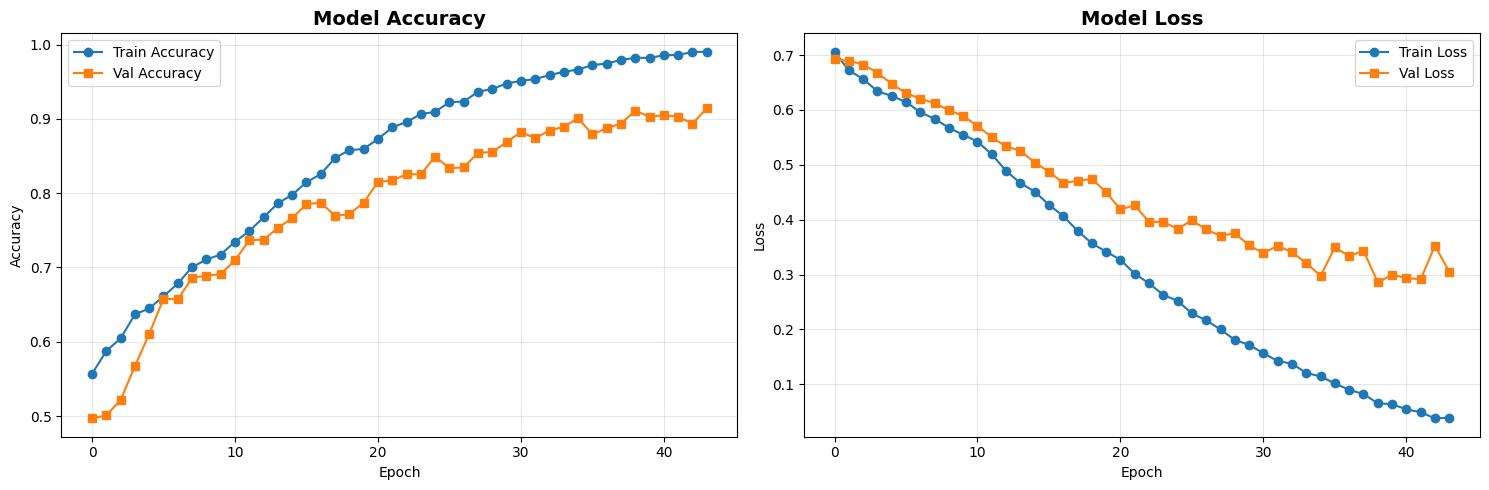

Final Training Accuracy: 0.9904
Final Validation Accuracy: 0.9143


In [34]:
# Plot Accuracy and Loss curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pcg_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [35]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print("=" * 50)
print("TEST SET EVALUATION")
print("=" * 50)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")
print("=" * 50)

TEST SET EVALUATION
Loss: 0.2859
Accuracy: 0.9112
Precision: 0.8798
Recall: 0.9525
F1-Score: 0.9147


In [36]:
# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nCLASSIFICATION REPORT")
print("=" * 60)
report = classification_report(
    y_test, y_pred,
    target_names=['Normal (0)', 'Abnormal (1)'],
    digits=4
)
print(report)

# Additional metrics
from sklearn.metrics import roc_auc_score, matthews_corrcoef

roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"\nROC-AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Normal (0)     0.9482    0.8698    0.9073       484
Abnormal (1)     0.8798    0.9525    0.9147       484

    accuracy                         0.9112       968
   macro avg     0.9140    0.9112    0.9110       968
weighted avg     0.9140    0.9112    0.9110       968


ROC-AUC Score: 0.9562
Matthews Correlation Coefficient: 0.8251


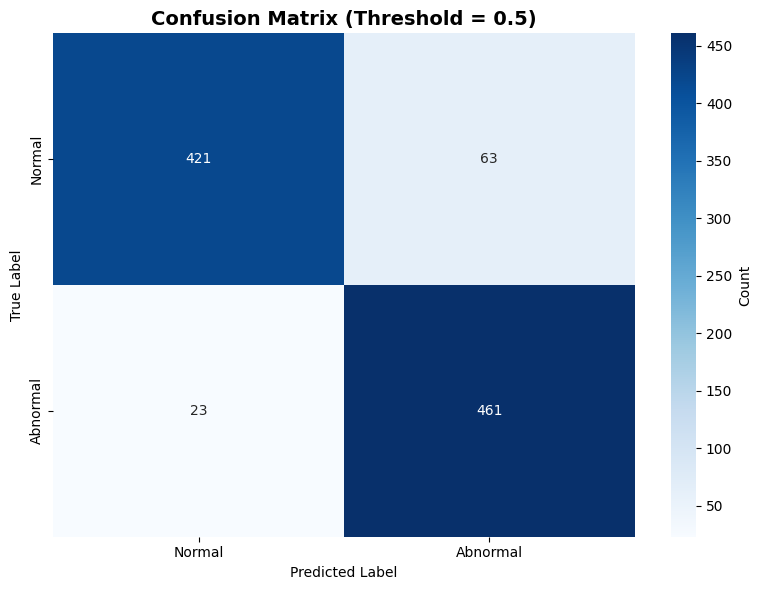


Confusion Matrix (Counts):
[[421  63]
 [ 23 461]]

Confusion Matrix (Percentages):
[[86.98347107 13.01652893]
 [ 4.75206612 95.24793388]]

Sensitivity (Recall): 0.9525 (95.25%)
Specificity: 0.8698 (86.98%)


In [43]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Abnormal'],
    yticklabels=['Normal', 'Abnormal'],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix (Threshold = 0.5)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('pcg_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Counts):")
print(cm)
print("\nConfusion Matrix (Percentages):")
print(cm_percent)

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"\nSensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")

In [45]:
# Save the trained model
MODEL_SAVE_PATH = r'drive/MyDrive/pcg_crnn_model.keras'
HISTORY_SAVE_PATH = r'drive/MyDrive/pcg_training_history.npy'

# Create directory if it doesn't exist (if saving to a subdirectory within MyDrive)
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Save model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

# Save training history
np.save(HISTORY_SAVE_PATH, history.history)
print(f"Training history saved to: {HISTORY_SAVE_PATH}")

Model saved to: drive/MyDrive/pcg_crnn_model.keras
Training history saved to: drive/MyDrive/pcg_training_history.npy
